## Testando Prompt (usando create_pandas_dataframe_agent)
Observações: aqui o prompt já é pre-made, portanto para alterar ele devo adicionar prefixo e/ou sufixo.

### Tokens e imports

In [111]:
# default
import os
from getpass import getpass
import pandas as pd
from typing import Annotated
from typing_extensions import TypedDict

# langchain 
from langgraph.graph.message import add_messages
from langchain.agents import tool
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langchain.tools.render import render_text_description

from langchain_community.chat_models import ChatDeepInfra
from langchain_community.tools.tavily_search import TavilySearchResults

from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.prompts import HumanMessagePromptTemplate

from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent


from dotenv import load_dotenv
from pydantic import BaseModel

from typing import List, Optional, Tuple
from typing_extensions import Literal
from pydantic import BaseModel, Field

In [112]:
os.environ["DEEPINFRA_API_TOKEN"] = getpass("Digite sua chave da DeepInfra: ")

In [113]:
os.environ["TAVILY_API_KEY"] = getpass("Digite sua chave do Travily: ")
#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

### Definindo Tools
Aqui definirei as tools do meu agente. Estou responsável por colocar tools relacionadas a imputação de valores.
Irei colocar algumas opções e tentar explicar as características de cada uma, para que o agente decida qual o melhor.

In [114]:
df = pd.read_csv("./datasets/pems03.csv")
print(f"DataFrame global carregado com {df.shape[0]} linhas e {df.shape[1]} colunas.")
num_cols = df.select_dtypes(include=['number']).columns.tolist()
df_head = df.head()
df_describe = df.describe()
print(f"DataFrame global:\n{ df_describe}\n")
print(f"Primeiras linhas do DataFrame:\n{df_head}")
print(f"Colunas numéricas: {num_cols}")
df.shape, df.columns[:5], df.index[:5]
miss_ratio = df.isna().mean()
miss_ratio.describe(), miss_ratio.sort_values(ascending=False).head(10)



DataFrame global carregado com 26208 linhas e 359 colunas.
DataFrame global:
             313344        313349        313438        313450        313487  \
count  26208.000000  26208.000000  26208.000000  26208.000000  26208.000000   
mean     120.401748    117.716346    289.478938    287.617331    156.525298   
std       76.841761     74.917534    160.399367    159.140895     87.084462   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       46.000000     45.000000    125.000000    124.000000     77.000000   
50%      128.000000    126.000000    331.000000    332.000000    170.000000   
75%      176.000000    171.000000    428.000000    427.000000    218.000000   
max      339.000000    340.000000    595.000000    579.000000    400.000000   

             313493        313512        313551        313552        317752  \
count  26208.000000  26208.000000  26208.000000  26208.000000  26208.000000   
mean     300.305746    246.577801    114.697039    11

(count    359.0
 mean       0.0
 std        0.0
 min        0.0
 25%        0.0
 50%        0.0
 75%        0.0
 max        0.0
 dtype: float64,
 313339       0.0
 timestamp    0.0
 313344       0.0
 313349       0.0
 313438       0.0
 313450       0.0
 313487       0.0
 317168       0.0
 317166       0.0
 317157       0.0
 dtype: float64)

In [115]:
class NormalizacaoSchema(BaseModel):
    columns: List[str] = Field(
        description="Lista de colunas numéricas a normalizar. Use '*' para todas as colunas numéricas."
    )
    method: Literal["minmax", "zscore"] = Field(
        description="Método de normalização. minmax -> escala entre [a,b], zscore -> média 0 e desvio 1."
    )
    feature_range: Optional[Tuple[float, float]] = Field(
        default=(0.0, 1.0),
        description="Faixa desejada para o método minmax. Ignorado para zscore."
    )
    imputar: bool = Field(
        default=False,
        description="Se True, preenche valores faltantes antes de normalizar."
    )
    imputacao_metodo: Literal["ffill", "bfill", "linear"] = Field(
        default="ffill",
        description="Método simples de imputação caso imputar=True."
    )


In [116]:
@tool(args_schema=NormalizacaoSchema)
def normalizacao_tool(
    columns: List[str],
    method: str,
    feature_range: Optional[Tuple[float, float]] = (0.0, 1.0),
    imputar: bool = False,
    imputacao_metodo: str = "ffill"
) -> str:
    """
    Normaliza colunas numéricas de séries temporais para faixas padrão.

    Métodos:
    - minmax: Escala valores para um intervalo definido (default [0,1])
    - zscore: Padroniza valores para média 0 e desvio padrão 1

    Quando usar:
    - Antes de aplicar modelos de machine learning ou comparações diretas entre sensores.
    - Útil em bases com escalas muito diferentes por coluna.

    Notas:
    - Se houver valores faltantes e imputar=True, aplica imputação simples antes.
    - Colunas constantes recebem valor fixo (0 no zscore, a no minmax).
    """
    global df


In [117]:
#Selecionar colunas-alvo
import pandas as pd
from typing import List, Tuple, Optional, Dict, Any

_num_cols_all = df.select_dtypes(include=["number"]).columns.tolist()

_exclude = {"timestamp"}  
TARGET_COLS_DEFAULT = [c for c in _num_cols_all if c not in _exclude]

len(TARGET_COLS_DEFAULT), TARGET_COLS_DEFAULT[:5]

#Guardar parâmetros por coluna e método
NORMALIZATION_STATE: Dict[Tuple[str, str], Dict[str, Any]] = {}

def _state_key(method: str, col: str) -> Tuple[str, str]:
    return (method, col)


#FIT
def fit_minmax(series: pd.Series, feature_range: Tuple[float, float]=(0.0, 1.0)) -> Dict[str, float]:
    a, b = feature_range
    vmin = float(series.min())
    vmax = float(series.max())
    return {"min": vmin, "max": vmax, "a": a, "b": b}

def fit_zscore(series: pd.Series) -> Dict[str, float]:
    mean = float(series.mean())
    std = float(series.std(ddof=0))  
    return {"mean": mean, "std": std}

#TRANSFORM
def transform_minmax(series: pd.Series, params: Dict[str, float]) -> pd.Series:
    vmin, vmax, a, b = params["min"], params["max"], params["a"], params["b"]
    denom = (vmax - vmin)
    if denom == 0: 
        return pd.Series(a, index=series.index, dtype=float)
    scaled = (series - vmin) / denom
    return a + scaled * (b - a)

def transform_zscore(series: pd.Series, params: Dict[str, float]) -> pd.Series:
    mean, std = params["mean"], params["std"]
    if std == 0:  
        return pd.Series(0.0, index=series.index, dtype=float)
    return (series - mean) / std

#INVERSE
def inverse_minmax(series: pd.Series, params: Dict[str, float]) -> pd.Series:
    vmin, vmax, a, b = params["min"], params["max"], params["a"], params["b"]
    if (b - a) == 0:
        return pd.Series(vmin, index=series.index, dtype=float)
    return vmin + (series - a) * (vmax - vmin) / (b - a)

def inverse_zscore(series: pd.Series, params: Dict[str, float]) -> pd.Series:
    mean, std = params["mean"], params["std"]
    return series * std + mean


In [118]:
'''def normalize_columns(
    df: pd.DataFrame,
    columns: List[str],
    method: str = "minmax",
    feature_range: Tuple[float, float]=(0.0, 1.0),
    create_suffix: str = "_norm",
    clip_output: Optional[Tuple[float, float]] = None,  # ex.: (0,1) só pra visual
) -> List[str]:
    """
    Normaliza colunas e cria novas colunas com sufixo (não sobrescreve).
    Salva parâmetros em NORMALIZATION_STATE.
    Retorna a lista de colunas criadas.
    """
    created = []
    for col in columns:
        s = df[col].astype(float)

        if method == "minmax":
            params = fit_minmax(s, feature_range)
            out = transform_minmax(s, params)
        elif method == "zscore":
            params = fit_zscore(s)
            out = transform_zscore(s, params)
        else:
            raise ValueError("Método não suportado (use 'minmax' ou 'zscore').")

        if clip_output is not None:
            lo, hi = clip_output
            out = out.clip(lower=lo, upper=hi)

        NORMALIZATION_STATE[_state_key(method, col)] = params

        out_col = f"{col}{create_suffix}"
        df[out_col] = out
        created.append(out_col)

    return created

test_cols = TARGET_COLS_DEFAULT[:2]
created = normalize_columns(df, test_cols, method="minmax", feature_range=(0.0, 1.0))
created, df[created].describe().loc[["min","max"]]
'''

'def normalize_columns(\n    df: pd.DataFrame,\n    columns: List[str],\n    method: str = "minmax",\n    feature_range: Tuple[float, float]=(0.0, 1.0),\n    create_suffix: str = "_norm",\n    clip_output: Optional[Tuple[float, float]] = None,  # ex.: (0,1) só pra visual\n) -> List[str]:\n    """\n    Normaliza colunas e cria novas colunas com sufixo (não sobrescreve).\n    Salva parâmetros em NORMALIZATION_STATE.\n    Retorna a lista de colunas criadas.\n    """\n    created = []\n    for col in columns:\n        s = df[col].astype(float)\n\n        if method == "minmax":\n            params = fit_minmax(s, feature_range)\n            out = transform_minmax(s, params)\n        elif method == "zscore":\n            params = fit_zscore(s)\n            out = transform_zscore(s, params)\n        else:\n            raise ValueError("Método não suportado (use \'minmax\' ou \'zscore\').")\n\n        if clip_output is not None:\n            lo, hi = clip_output\n            out = out.clip(low

In [119]:
'''created_z = normalize_columns(df, test_cols, method="zscore")
df[created_z].describe().loc[["mean","std"]]'''


'created_z = normalize_columns(df, test_cols, method="zscore")\ndf[created_z].describe().loc[["mean","std"]]'

In [120]:
'''col = test_cols[0]
minmax_params = NORMALIZATION_STATE[_state_key("minmax", col)]
z_params = NORMALIZATION_STATE[_state_key("zscore", col)]

orig = df[col].astype(float)
x_minmax = df[f"{col}_norm"]
x_back = inverse_minmax(x_minmax, minmax_params)

x_z = df[f"{col}_norm"]  # cuidado: se você normalizou 2 vezes, pegue a certa
x_back_z = inverse_zscore(df[f"{col}_norm"], z_params)  # ajuste se necessário

float((orig - x_back).abs().mean()), float((orig - x_back_z).abs().mean())'''


'col = test_cols[0]\nminmax_params = NORMALIZATION_STATE[_state_key("minmax", col)]\nz_params = NORMALIZATION_STATE[_state_key("zscore", col)]\n\norig = df[col].astype(float)\nx_minmax = df[f"{col}_norm"]\nx_back = inverse_minmax(x_minmax, minmax_params)\n\nx_z = df[f"{col}_norm"]  # cuidado: se você normalizou 2 vezes, pegue a certa\nx_back_z = inverse_zscore(df[f"{col}_norm"], z_params)  # ajuste se necessário\n\nfloat((orig - x_back).abs().mean()), float((orig - x_back_z).abs().mean())'

In [121]:
class NormalizacaoSchema(BaseModel):
    columns: List[str] = Field(
        description="Lista de colunas numéricas a normalizar. Use '*' para todas as colunas numéricas."
    )
    method: Literal["minmax", "zscore"] = Field(
        description="Método de normalização: minmax (escala [a,b]) ou zscore (média 0, desvio 1)."
    )
    feature_range: Optional[Tuple[float, float]] = Field(
        default=(0.0, 1.0),
        description="Faixa alvo para minmax. Ignorado para zscore."
    )
    imputar: bool = Field(
        default=False,
        description="Se True, preenche valores faltantes antes de normalizar."
    )
    imputacao_metodo: Literal["ffill", "bfill", "linear"] = Field(
        default="ffill",
        description="Método de imputação simples, usado se imputar=True."
    )
    clip_output: Optional[Tuple[float, float]] = Field(
        default=None,
        description="Faixa para cortar valores após normalizar (ex.: (0,1))."
    )

@tool(args_schema=NormalizacaoSchema)
def normalizacao_tool(
    columns: List[str],
    method: str,
    feature_range: Optional[Tuple[float, float]] = (0.0, 1.0),
    imputar: bool = False,
    imputacao_metodo: str = "ffill",
    clip_output: Optional[Tuple[float, float]] = None
) -> str:
    """
    Normaliza colunas numéricas de séries temporais.
    
    Métodos:
    - minmax: escala valores para [a,b]
    - zscore: padroniza para média 0 e desvio 1
    
    Funcionalidades:
    - Pode imputar valores faltantes antes da normalização.
    - Salva parâmetros por coluna para possível inverse transform.
    - Cria novas colunas com sufixo '_norm' (não sobrescreve originais).
    """
    global df
    global NORMALIZATION_STATE

    # 1) Determinar colunas alvo
    if columns == ["*"]:
        num_cols = df.select_dtypes(include=["number"]).columns.tolist()
        columns = [c for c in num_cols if c.lower() != "timestamp"]

    # 2) Imputação opcional
    if imputar:
        simple_impute(df, columns, method=imputacao_metodo)

    # 3) Normalização por coluna
    created_cols = []
    for col in columns:
        s = df[col].astype(float)

        if method == "minmax":
            params = fit_minmax(s, feature_range)
            out = transform_minmax(s, params)
        elif method == "zscore":
            params = fit_zscore(s)
            out = transform_zscore(s, params)
        else:
            raise ValueError("Método não suportado. Use 'minmax' ou 'zscore'.")

        if clip_output is not None:
            lo, hi = clip_output
            out = out.clip(lower=lo, upper=hi)

        # Salvar parâmetros
        NORMALIZATION_STATE[_state_key(method, col)] = params

        # Criar nova coluna
        out_col = f"{col}_norm"
        df[out_col] = out
        created_cols.append(out_col)

    return f"Normalização '{method}' aplicada em {len(columns)} colunas. Colunas criadas: {created_cols[:5]}{'...' if len(created_cols) > 5 else ''}"


In [122]:
from pydantic import BaseModel, Field
from typing import List, Literal, Optional, Tuple

class InverseNormalizacaoSchema(BaseModel):
    columns: List[str] = Field(
        description="Lista de colunas ORIGINAIS a reverter (sem sufixo). Ex.: ['313344', '313349']"
    )
    method: Literal["minmax", "zscore"] = Field(
        description="Método que foi usado na normalização."
    )
    source_suffix: str = Field(
        default="_norm",
        description="Sufixo da coluna normalizada de origem (ex.: '_norm')."
    )
    output_suffix: str = Field(
        default="_denorm",
        description="Sufixo da coluna de saída com valores na escala original."
    )


In [123]:
@tool(args_schema=InverseNormalizacaoSchema)
def inverse_normalizacao_tool(
    columns: List[str],
    method: str,
    source_suffix: str = "_norm",
    output_suffix: str = "_denorm",
) -> str:
    """
    Reverte a normalização de colunas previamente normalizadas.
    - Lê colunas normalizadas (ex.: 'col_norm') e cria 'col_denorm' com a escala original.
    - Usa os parâmetros salvos em NORMALIZATION_STATE[(method, col)].
    """
    global df
    global NORMALIZATION_STATE

    not_found_params = []
    not_found_source = []
    created = []

    for col in columns:
        src_col = f"{col}{source_suffix}"
        out_col = f"{col}{output_suffix}"

        # 1) Verifica se a coluna normalizada existe
        if src_col not in df.columns:
            not_found_source.append(src_col)
            continue

        # 2) Recupera params do estado
        key = (method, col)
        if key not in NORMALIZATION_STATE:
            not_found_params.append(col)
            continue
        params = NORMALIZATION_STATE[key]

        # 3) Aplica inverse conforme método
        s = df[src_col].astype(float)
        if method == "minmax":
            out = inverse_minmax(s, params)
        elif method == "zscore":
            out = inverse_zscore(s, params)
        else:
            raise ValueError("Método não suportado. Use 'minmax' ou 'zscore'.")

        df[out_col] = out
        created.append(out_col)

    msg = [f"Inverse '{method}' aplicado em {len(created)} colunas."]
    if created:
        msg.append(f"Colunas criadas: {created[:5]}{'...' if len(created) > 5 else ''}")
    if not_found_source:
        msg.append(f"Aviso: colunas normalizadas não encontradas: {not_found_source[:5]}{'...' if len(not_found_source) > 5 else ''}")
    if not_found_params:
        msg.append(f"Aviso: parâmetros ausentes em NORMALIZATION_STATE para: {not_found_params[:5]}{'...' if len(not_found_params) > 5 else ''}")

    return " ".join(msg)


In [124]:
class SchemaTools(BaseModel):
    coluna: str

@tool(args_schema=SchemaTools)
def interpolacao_temporal(column_name: str, method: str = 'spline') -> str:
    """
    Preenche valores faltantes em séries temporais UNIVARIADAS usando métodos baseados em tempo.
    
    Métodos disponíveis:
    - 'spline': Spline cúbico (ideal para dados suaves e contínuos)
    - 'linear': Interpolação linear (simples, mas menos precisa)
    - 'ffill': Preenchimento com último valor válido (para dados persistentes)
    - 'bfill': Preenchimento com próximo valor válido (útil em dados recentes)
    
    Quando usar:
    - Dados de sensor, métricas contínuas, séries com padrões suaves.
    - Evitar em séries muito voláteis ou com sazonalidade complexa.
    """
    global df
    if method == 'spline':
        df[column_name] = df[column_name].interpolate(method='spline', order=3)
    elif method == 'linear':
        df[column_name] = df[column_name].interpolate(method='linear')
    elif method == 'ffill':
        df[column_name] = df[column_name].ffill()
    elif method == 'bfill':
        df[column_name] = df[column_name].bfill()
    
    return f"Imputação temporal ({method}) aplicada em {column_name}."


@tool()
def imputacao_mice_temporal() -> str:
    """
    Imputação MICE (Multiple Imputation by Chained Equations) com variáveis temporais.
    
    Quando usar:
    - Dados multivariados (ex: múltiplos sensores) onde variáveis se correlacionam.
    - Séries com padrões de missing aleatórios (não em blocos grandes).
    
    Adiciona automaticamente:
    - Lags temporais (valores passados)
    - Médias móveis (suaviza variações)
    - Tendência temporal (evita viés)
    """
    global df
    from sklearn.experimental import enable_iterative_imputer
    from sklearn.impute import IterativeImputer

    # Adiciona features temporais automaticamente
    for col in df.columns:
        df[f'{col}_lag1'] = df[col].shift(1)  # Valor anterior
        df[f'{col}_rolling_mean'] = df[col].rolling(3).mean()  # Média móvel

    imputer = IterativeImputer(max_iter=10, random_state=0)
    df[:] = imputer.fit_transform(df)
    
    return "Imputação MICE com variáveis temporais aplicada."

@tool(args_schema=SchemaTools)
def filtro_kalman(column_name: str) -> str:
    """
    Filtro de Kalman para séries temporais com ruído ou tendência.
    
    Quando usar:
    - Dados de sensores com medições imprecisas.
    - Séries com tendência (ex: temperatura, preços).
    - Casos onde a ordem temporal é crítica.
    
    Limitações:
    - Requer ajuste manual para séries muito irregulares.
    """
    global df
    from pykalman import KalmanFilter

    kf = KalmanFilter(
        initial_state_mean=df[column_name].mean(),
        observation_covariance=0.5,
        transition_covariance=0.1
    )
    
    # Aplica o filtro
    observed = df[column_name].values
    imputed = kf.smooth(observed)[0].flatten()
    df[column_name] = imputed
    
    return f"Filtro de Kalman aplicado em {column_name}."

@tool(args_schema=SchemaTools)
def decomposicao_sazonal(column_name: str) -> str:
    """
    Separa tendência, sazonalidade e resíduos para imputação mais precisa.
    
    Quando usar:
    - Séries com padrões sazonais claros (ex: vendas, tráfego).
    - Dados com missing em padrões periódicos.
    
    Método:
    1. Decompõe a série em tendência, sazonalidade e ruído.
    2. Interpola a tendência.
    3. Recompõe a série.
    """
    global df
    from statsmodels.tsa.seasonal import STL

    stl = STL(df[column_name], period=24, robust=True)
    res = stl.fit()
    
    # Preenche apenas a tendência (ignora ruído)
    df[column_name] = res.trend + res.seasonal
    
    return f"Decomposição sazonal aplicada em {column_name}."   

In [125]:
tavily = TavilySearchResults(max_results=2)

tools = [
    tavily,
    get_column_names,
    summary_statistics,
    value_counts,
    check_missing_values,
    calculate_correlation,
]

llm = ChatDeepInfra(model="meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8", temperature=0)
agent = create_pandas_dataframe_agent(
    llm = llm,
    df= pd.DataFrame(df),
    verbose=True,
    allow_dangerous_code=True,
    return_intermediate_steps=True, # Retorna tb os pensamentos e ações do agente
    agent_type="zero-shot-react-description",
    extra_tools = tools,
    max_interations = 10,
    prefix = """
        Você é um analista de dados especialista em Análise Exploratória de Dados (EDA), com foco principal em datasets de séries temporais. Sua tarefa é usar as ferramentas disponíveis para extrair insights valiosos e responder às perguntas do usuário.
        Você tem acesso a ferramentas de manipulação e análise de dados (pandas), algumas ferramentas extras de manipulação e, crucialmente, uma ferramenta de pesquisa (`tavily`).

        Siga estas diretrizes rigorosas para sua análise:
    1.  **Compreensão Inicial**: Comece sempre com uma visão geral do dataframe, verificando os tipos de dados, valores ausentes, estatísticas descritivas e as primeiras/últimas linhas para entender a estrutura dos dados.
    2.  **Análise de Série Temporal**: Priorize técnicas de EDA específicas para séries temporais. Considere visualizações, decomposição de séries temporais (tendência, sazonalidade, resíduo), autocorrelação (ACF/PACF) e análise de estacionaridade.
    3.  **Uso Inteligente de Ferramentas**:
        * Utilize as ferramentas para qualquer operação direta no dataframe.
        * **Se você encontrar um problema complexo, uma metodologia que não conhece, ou se precisar de informações adicionais para interpretar um resultado (e.g., o que é um determinado conceito estatístico de série temporal, melhores práticas para lidar com certo tipo de anomalia, ou sobre um domínio específico que o dado representa), USE a ferramenta `tavily` para pesquisar antes de tomar uma decisão ou responder.**
        * **Não invente respostas.** Se uma pergunta não pode ser respondida com as ferramentas disponíveis ou com pesquisa, declare isso claramente.
    4.  **Clareza e Precisão**: Suas respostas devem ser claras, concisas e baseadas em evidências do dataset ou da pesquisa. Explique os insights de forma acessível.
    5.  **Iteração**: Se uma pergunta inicial não for totalmente respondida ou se você identificar um caminho de análise promissor, sugira os próximos passos.

    Sua meta é ser um assistente proativo e investigativo, garantindo que a EDA seja completa e perspicaz, especialmente para dados de séries temporais.
    """ , 
    sufix = "O nome do dataframe é df e ele representa uma série temporal."    
)

NameError: name 'get_column_names' is not defined

In [ ]:
# imports (ajuste conforme sua instalação)
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
from langchain.agents import AgentType
from langchain_community.chat_models import ChatDeepInfra  # ou o import correto no seu ambiente

llm = ChatDeepInfra(model="meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8", temperature=0)

# SOMENTE as tools que você criou
tools = [normalizacao_tool, inverse_normalizacao_tool]

agent = create_pandas_dataframe_agent(
    llm=llm,
    df=df,
    agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True,
    allow_dangerous_code=True,
    max_iterations=10,
    prefix="Use APENAS as ferramentas de normalização (minmax/zscore).",
    suffix="O dataframe se chama df.",
    agent_executor_kwargs={"return_intermediate_steps": True},
    tools=tools,  # se der TypeError, troque para extra_tools=tools
)


### Definições LangChain

In [126]:
class State(TypedDict):
    messages: list
    logs: list
    all_tool_outputs: list

graph_builder = StateGraph(State)

In [128]:
from typing import List, TypedDict
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage
from langgraph.graph import StateGraph, END

# Estado do grafo
class State(TypedDict):
    messages: List[AnyMessage]

# Nó que usa o agent vindo pelo config
def chatbot(state: State, config):
    # recupera o agent passado na invocation
    agent = config["configurable"]["agent"]
    user_text = state["messages"][-1].content  # último HumanMessage

    # PROMPT ajustado: só usar nossas tools de normalização
    system_guard = (
        "Use APENAS as ferramentas de normalização disponíveis (minmax ou zscore). "
        "Não use KNN, não remova outliers, nem outras técnicas."
    )
    # junta instrução de guarda + pedido do usuário
    input_text = f"{system_guard}\n\nTarefa: {user_text}"

    out = agent.invoke({"input": input_text})
    # o pandas agent costuma devolver dict com 'output'
    answer = out.get("output", str(out))
    return {"messages": [AIMessage(content=answer)]}

# Monta o grafo
graph = StateGraph(State)
graph.add_node("chatbot", chatbot)
graph.set_entry_point("chatbot")
graph.add_edge("chatbot", END)
app = graph.compile()

# --- INVOCAR ---
from langchain_core.messages import HumanMessage

estado = app.invoke(
    {"messages": [HumanMessage(content="Aplique minmax [0,1] na coluna 313344 e reporte min e max de 313344_norm.")]},
    config={"configurable": {"agent": agent}}  # <-- passa o agent aqui
)


NameError: name 'agent' is not defined

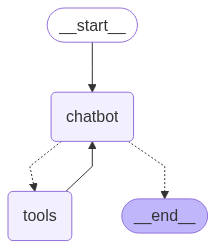

In [ ]:
graph_builder.add_edge(START, "chatbot")

# As arestas condicionais e de volta para o chatbot
graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")


checkpointer = MemorySaver()
config = {
    "configurable": {
        "model": llm,
        "thread_id": "1"
    }
}
graph = graph_builder.compile(checkpointer=checkpointer)
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

### Agent Prompting
Essa é a parte que estava focando. Estava tentando usar "Iterative Refinement Prompting" & "Reasoning and Acting"
Entretanto o próprio agent_dataframe ja faz essas coisas, então apenas usei o prefixo com a estratégia de persona, e o sufixo com informações do dataset.


### Tentando conversar com o agente

In [ ]:
estado = graph.invoke({"messages": [HumanMessage(content="Utilize a ferramenta de normalização para escalar os valores da(s) coluna(s) indicada(s)")]}, config)

NameError: name 'agent' is not defined

In [ ]:
estado["messages"]

NameError: name 'estado' is not defined

In [ ]:
estado = graph.invoke({"messages": [HumanMessage(content="Me forneça uma informação interessante sobre o dataset sem usar as ferramentas apresentadas no prompt, apenas usando seus proprios conhecimentos em pandas")]}, config)



> Entering new AgentExecutor chain...
Thought: Para fornecer uma informação interessante sobre o dataset sem usar as ferramentas apresentadas, posso carregar o dataset em um DataFrame do pandas e realizar uma análise básica. Primeiramente, preciso entender a estrutura do dataset.

Action: python_repl_ast
Action Input: 
```python
import pandas as pd

# Carregar o dataset
df = pd.read_csv('dataset.csv')

# Verificar as primeiras linhas do dataset
print(df.head())
```
FileNotFoundError: [Errno 2] No such file or directory: 'dataset.csv'Para fornecer uma informação interessante sobre o dataset sem usar as ferramentas apresentadas, posso carregar o dataset em um DataFrame do pandas e realizar uma análise básica. Primeiramente, preciso entender a estrutura do dataset.

Action: python_repl_ast
Action Input:
```python
import pandas as pd

# O dataset já está carregado em 'df', então posso usar 'df' diretamente
# Verificar as primeiras linhas do dataset
print(df.head())

# Verificar informaçõ

In [ ]:
estado["messages"]

[{'input': [HumanMessage(content='Me forneça uma informação interessante sobre o dataset sem usar as ferramentas apresentadas no prompt, apenas usando seus proprios conhecimentos em pandas', additional_kwargs={}, response_metadata={})],
  'output': 'O dataset é uma série temporal com 5 registros, contendo uma coluna de timestamp e várias colunas numéricas com valores variados.',
  'intermediate_steps': [(AgentAction(tool='python_repl_ast', tool_input="```python\nimport pandas as pd\n\n# Carregar o dataset\ndf = pd.read_csv('dataset.csv')\n\n# Verificar as primeiras linhas do dataset\nprint(df.head())\n```\n", log="Thought: Para fornecer uma informação interessante sobre o dataset sem usar as ferramentas apresentadas, posso carregar o dataset em um DataFrame do pandas e realizar uma análise básica. Primeiramente, preciso entender a estrutura do dataset.\n\nAction: python_repl_ast\nAction Input: \n```python\nimport pandas as pd\n\n# Carregar o dataset\ndf = pd.read_csv('dataset.csv')\n\n